# Extracellular
Generates data from simulated extracellular recordings for studying with spike sorting etc. We run the same simulation as in DryWetLab, but use extracellular measurements to count spikes and check interspike interval distribution.

In [11]:
%matplotlib nbagg
import numpy as np
import scipy.signal as spsig
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm_notebook as tqdm

from colorednoise import powerlaw_psd_gaussian as gen_noise
from braingeneers import drylab

In [31]:
# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 800

# How much stronger inhibitory connections are than excitatory ones.
inhibition_factor = 2

# Used for constructing nonhomogeneous neural populations,
# interpolated between two types based on the value of
# r ∈ [0,1]. Excitatory neurons go from Regular Spiking
# to Chattering, while inhibitory neurons go from
# Low-Threshold Spiking to Late Spiking models over the
# same range. Adapted from Izhikevich's writings.
r = np.random.rand(N) # unitless
l = np.ones(N) # unitless

# a : 1/ms recovery time constant of membrane leak currents
a = np.hstack((0.03*l[:Ne], 0.03 + 0.14*r[Ne:]))
# b : nS recovery conductivity
b = np.hstack((-2 + 3*r[:Ne]**2, 8 - 3*r[Ne:]))
# c : mV voltage of the downstroke
c = np.hstack((-50 + 10*r[:Ne]**2, -53 + 8*r[Ne:]))
# d : pA instantaneous increase in leakage during downstroke
d = np.hstack((100 + 50*r[:Ne]**2, 20 + 80*r[Ne:]))
# C : pF membrane capacitance
C = np.hstack((100 - 50*r[:Ne]**2, 100 - 80*r[Ne:]))
# k : nS/mV Na+ voltage-gated channel conductivity parameter
k = np.hstack((0.7 + 0.8*r[:Ne]**2, 1 - 0.7*r[Ne:]))
# mV : resting membrane voltage
Vr = np.hstack((-60*l[:Ne], -56 - 10*r[Ne:]))
# mV : threshold voltage at u=0
Vt = np.hstack((-40*l[:Ne], -42 + 2*r[Ne:]))

# tau : ms time constant of synaptic current
tau = 20

# Sij : pA total EPSC generated in neuron i when neuron j fires.
mu, sigma = -0.702, 0.9355  # taken from Song (2005).
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
S *= np.median(C / tau)
S[:,Ne:] *= -inhibition_factor
S[Ne:,:Ne] *= 2 # make excitatory input to inhibitory cells stronger

excitatory = np.arange(N) < Ne
inhibitory = np.arange(N) >= Ne

# XY : um planar positions of the cells
XY = np.random.rand(2,N) * 70

In [134]:
tmax = 30001

n = drylab.Organoid(XY=XY, S=S*2, tau=tau,
                    a=a, b=b, c=c, d=d,
                    k=k, C=C, Vr=Vr, Vt=Vt)

n_probes = 8
theta = np.linspace(0, 2*np.pi, num=n_probes+1)[:-1]
points = np.array([np.cos(theta), np.sin(theta)]) * 30 + 35
u = drylab.UtahArray(#spacing=10, shape=(7,7), offset=(5,5),
                    points=points, activation=None, radius=1)
u.insert(n, Vr, 1/C)

pinks = 50*gen_noise(size=(N,tmax), exponent=1)

n.reset()

firings = []
states = np.zeros((tmax, n_probes))
for t in tqdm(range(tmax)):
    _, fired = n.step(pinks[:,t])
    states[t,:] = u.Vprobe()
    for i in range(N):
        if fired[i]:
            firings.append((t,i))

firings = np.array(firings)
firinge = excitatory[firings[:,1]]
firingi = inhibitory[firings[:,1]]

# Sanity Check
Plot the simulation results in terms of both firings and probe voltages.

<IPython.core.display.Javascript object>


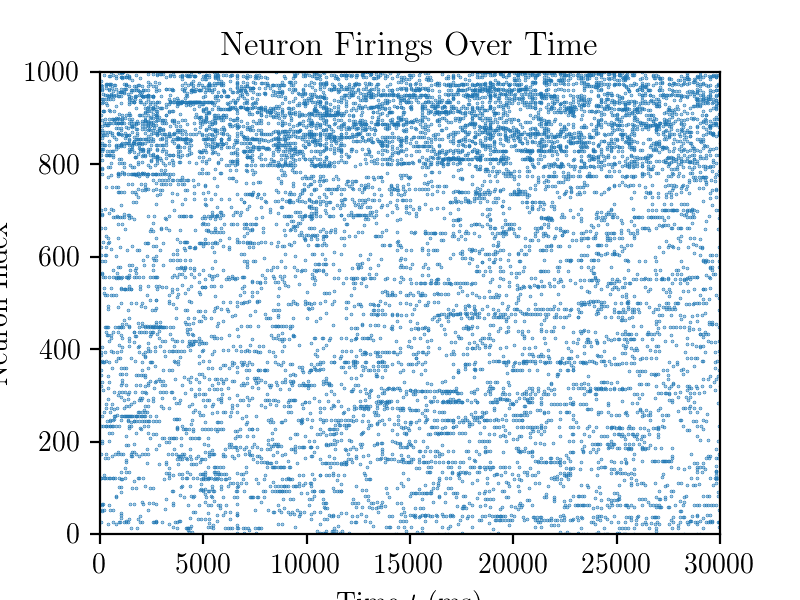

(0, 1000)

In [135]:
plt.figure(figsize=(4,3))
plt.plot(firings[:,0], firings[:,1], 
         '.', markersize=0.5, label='excitatory')
plt.title('Neuron Firings Over Time')
plt.xlabel('Time $t$ (ms)')
plt.ylabel('Neuron Index')
plt.xlim([0,tmax-1])
plt.ylim([0,1000])
None

<IPython.core.display.Javascript object>


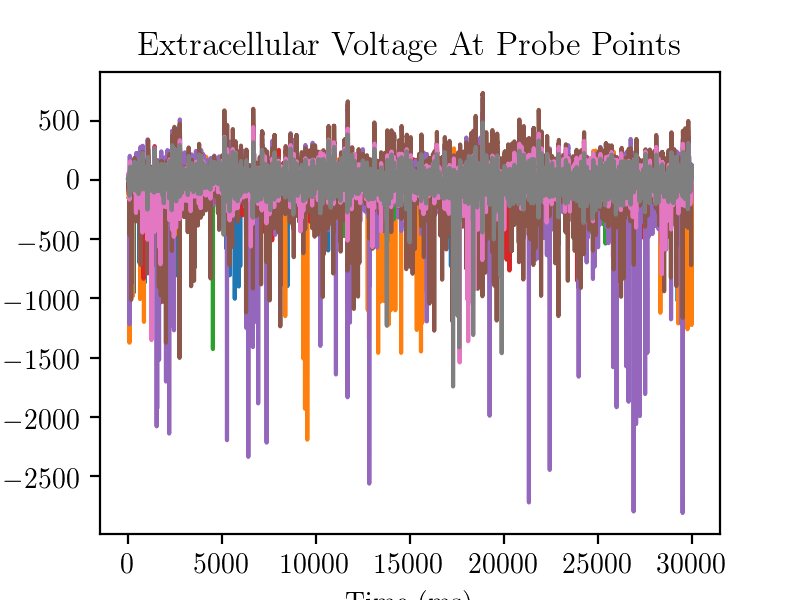

In [136]:
plt.figure(figsize=(4,3))
plt.plot(range(tmax), 1e3*states)
plt.title('Extracellular Voltage At Probe Points')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (\\textmu V)')
None

# Filtering
Electrophysiological data usually bandpass filters over something like 250Hz to 3kHz to remove LFPs. The sampling rate is only 1kHz here though, so there's no need for the high-cut part, just a high-pass at 250Hz.

In [137]:
def butter_highpass(cutoff, fs, order=5):
    return spsig.butter(order, 2*cutoff/fs, analog=False,
                        btype='high', output='sos')

In [138]:
sos = butter_highpass(250, fs=1000, order=3)
statesf = spsig.sosfilt(sos, states.T).T

<IPython.core.display.Javascript object>


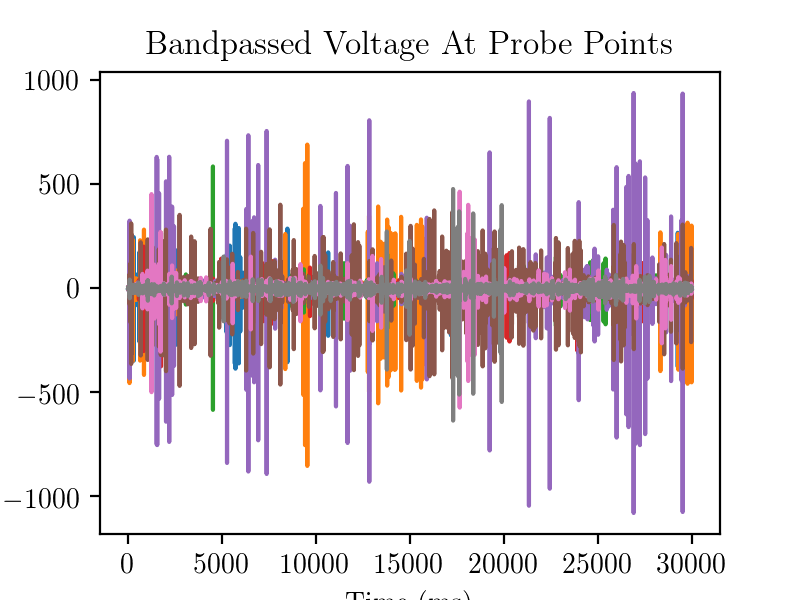

In [139]:
plt.figure(figsize=(4,3))
plt.plot(range(tmax), 1000*statesf)
plt.title('Bandpassed Voltage At Probe Points')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (\\textmu{m})')
None

# Rudimentary Spike Sorting
Use the same simple threshold-based method as Keith to find the times of and intervals between the spikes.

In [140]:
def find_spikes(x):
    """
    Finds spikes, where the voltage dips below -20uV, 
    and returns their onset times.
    """
    return (np.diff(np.int32(x < -20e-3), axis=0) == 1).nonzero()

In [141]:
spikes_per_channel = [find_spikes(statesf[:,channel])[0]
                     for channel in range(8)]

In [146]:
# Make a list of interspike intervals from all channels.
intervals = itertools.chain.from_iterable(
    [np.diff(spikes_per_channel[channel])
     for channel in range(8)])
intervals = np.array(list(intervals))

<IPython.core.display.Javascript object>


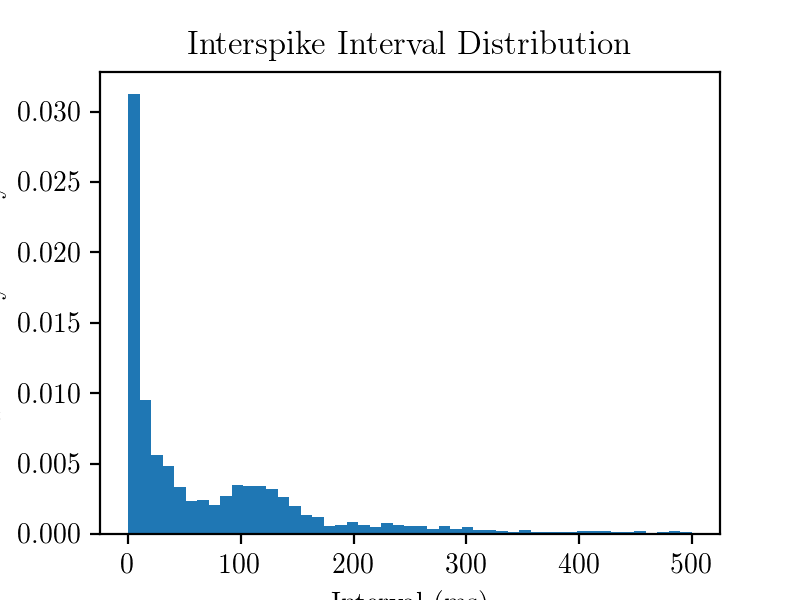

In [167]:
plt.figure(figsize=(4,3))
plt.hist(intervals, list(np.linspace(0,500)) + [np.inf], density=True)
plt.title('Interspike Interval Distribution')
plt.xlabel('Interval (ms)')
plt.ylabel('Probability Density')
None

# Probe Visualization
Just for fun, here's each cell colored according to which probe it's closest to and how much it contributes to that probe.

<IPython.core.display.Javascript object>


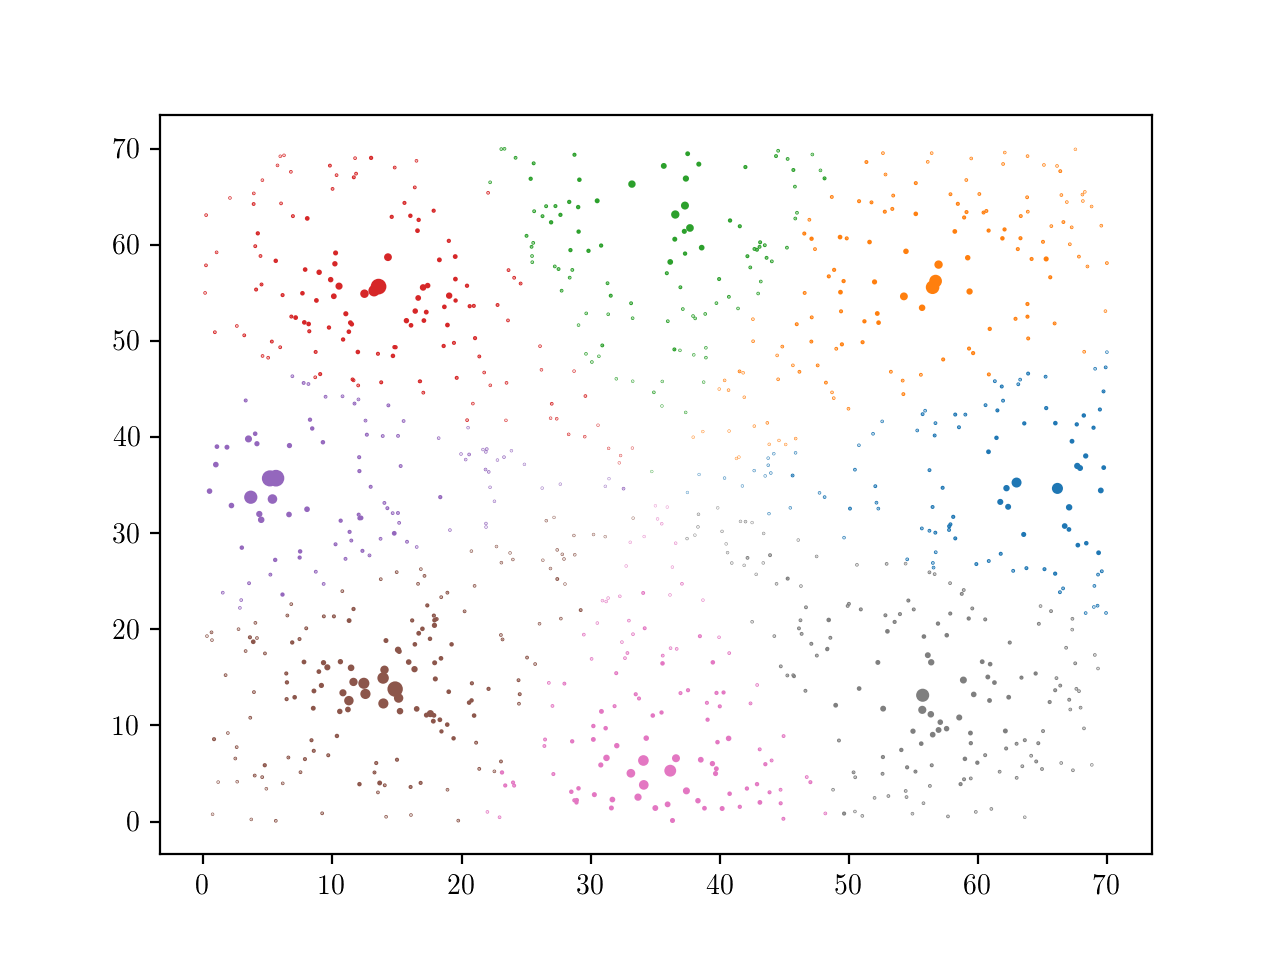

In [87]:
plt.figure()
iprobe = np.argmax(u.M, axis=1)
colors = ['C'+str(i) for i in iprobe]
plt.scatter(n.XY[0,:], n.XY[1,:], c=colors, 
            s=25 * np.max(u.M, axis=1) / np.max(u.M))